<a href="https://colab.research.google.com/github/bishoy576/Sentiment-Analysis-on-Movie-reviews/blob/main/logistic_regression_from_scratch_and_SGDcalsifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("sst", "default")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np


Reading the data and converting to numpy array


In [ ]:
x_train, y_train = np.array(dataset['train']['sentence']), np.array(dataset['train']['label'])
x_test, y_test = np.array(dataset['test']['sentence']), np.array(dataset['test']['label'])

We need to create a dictionary that maps each unique bigram to a different index. In this part we do excatly that

In [ ]:
# Function to generate bigrams from a sentence
def generate_bigrams(sentence):
    words = ["<s>"] +  sentence.lower().split() + ["<s>"]
    return np.array([list(words[i:i+2]) for i in range(len(words)-1)])
# Generate bigrams from the dataset
all_bigrams = [bigram for sentence in x_train for bigram in generate_bigrams(sentence)]

# Get unique bigrams and their counts
unique_bigrams = np.unique(all_bigrams, axis = 0)
# # Create a mapping of unique bigrams to indices
bigram_to_index = {tuple(bigram): idx for idx, bigram in enumerate(unique_bigrams)}
del unique_bigrams
del all_bigrams
# print(len(bigram_to_index))
print(bigram_to_index)


{('!', "'"): 0, ('!', "''"): 1, ('!', ')'): 2, ('!', '<s>'): 3, ('!?', "'"): 4, ('#', '3'): 5, ('#', '9'): 6, ('$', '1.8'): 7, ('$', '20'): 8, ('$', '40'): 9, ('$', '50-million'): 10, ('$', '8'): 11, ('$', '9'): 12, ('$', '99'): 13, ('&', 'about'): 14, ('&', 'augmented'): 15, ('&', 'christian'): 16, ('&', 'co.'): 17, ('&', 'heart-rate-raising'): 18, ('&', 'j'): 19, ('&', 'paulette'): 20, ('&', 'stitch'): 21, ('&', 'tonto'): 22, ('&', 'w'): 23, ('&', 'z-boys'): 24, ("'", '('): 25, ("'", ')'): 26, ("'", ','): 27, ("'", '-'): 28, ("'", '--'): 29, ("'", '.'): 30, ("'", '...'): 31, ("'", '20,000'): 32, ("'", ':'): 33, ("'", ';'): 34, ("'", '<s>'): 35, ("'", '?'): 36, ("'", '`'): 37, ("'", 'a'): 38, ("'", 'about'): 39, ("'", 'according'): 40, ("'", 'achievement'): 41, ("'", 'actors'): 42, ("'", 'advises'): 43, ("'", 'affections'): 44, ("'", 'ambitious'): 45, ("'", 'amusing'): 46, ("'", 'anarchy'): 47, ("'", 'and'): 48, ("'", 'anderson'): 49, ("'", 'anguish'): 50, ("'", 'anti-'): 51, ("'", 'a

This function will change every sentiment score to its corresponding class label

In [ ]:
def map_to_classes(arr):
  for i, el in enumerate(arr):
    if el <= 0.2:
      arr[i] = 0
    elif el <= 0.4:
      arr[i] = 1
    elif el <= 0.6:
      arr[i] = 2
    elif el <= 0.8:
      arr[i] = 3
    elif el <= 1:
      arr[i] = 4

Since the class labels are represented by small numbers e.g.: 0, 1, 2 we only need int8 to store this labels, so we change the dtypes of y_test and y-train to conserve memory

In [ ]:
map_to_classes(y_train)
y_train = y_train.astype(np.int8)
map_to_classes(y_test)
y_test = y_test.astype(np.int8)
print(y_train)

[3 4 3 ... 3 0 1]


this function is used to generate all the features for a given document e.g sentence. each feature is either a 1 or 0 indicating whether a certain bigram exists. we use our bigram_to_index dictionary to map the bigram to a certain index and set the value in this index to 1 if the bigram exists in the senetence

In [ ]:


def get_features (sentence) :
  N  = np.zeros(len(bigram_to_index), dtype=np.int8)
  chs = ['<s>'] + sentence.lower().split() + ['<s>']
  for w1, w2 in zip(chs, chs[1:]):
    if (w1, w2) in bigram_to_index:
      N[bigram_to_index[(w1, w2)]] = 1

  return  N
x = get_features("The Rock is destined to be the 21st Century 's new `` Conan")
print(np.sum(x == 1))


13


we start defining the function that will help us during the algorithm


softmax score calculates  the gscore y for a given training example x. theta is our weights matrix which is k x f where k is the number of classes and f is the number of features, b is our bias vector which is a k x 1 vector containing the bias for each class . the score is computed via the following eqution : y = W . x + b


In [ ]:
def SoftmaxScore(x, theta, b):
    score = np.dot(theta, x) + b
    return score

this computes the softmax function of a given score. it take a k x 1 vectors of scores y containing a certain score for each class . the output is also a k x 1 vector containing the softmax of each score  

In [ ]:
def SoftmaxFunction(score):
    epsilon = 1e-6
    exps = np.nan_to_num(np.exp(score)) + epsilon
    exp_sums = np.sum(exps)
    return exps / exp_sums

cross entropy loss is computed given a k x 1 vector of sofmax scores (probablities) p_hat of the classes  and a true probbality vector y that contains zero for each class except the true label for the sample

In [ ]:
def xentropyloss(y, p_hat):
    epsilon = 1e-6
    #we will add epsilon (really small number) to p_hat
    #before taking the log to avoid p_hat being 0
    loss = -np.sum(np.log(p_hat + epsilon) * y)
    return loss

weights are updated using the gradient of the loss function

In [ ]:
def GradientStep(p_hat, theta, y, x, lr, b):
    cost = p_hat - y
    dw = np.outer(cost, x)
    db = cost
    theta  = theta - lr * dw
    b = b - lr * db
    return theta, b

# Putting It All Together

we initialize our parameters as follows :

In [ ]:
lr = 0.01
n_inputs = 5  # k
n_outputs = len(bigram_to_index)  # f
epochs = 50
theta = np.zeros((n_inputs, n_outputs)).astype(np.float16)


In [ ]:
theta.shape


(5, 86500)

In [ ]:

b = np.zeros( (n_inputs, 1) ).astype(np.float16)
b.shape

(5, 1)

In [ ]:
yneo = np.zeros((5,1))
yneo.shape


(5, 1)

This is our main training loop , here we implemented the pseudo code from speech and language processing textbook from chapter 5 reading

In [ ]:
epochs = 10
np.random.seed(42)

for epoch in range(epochs):
    shuffled_indeces = np.random.permutation(range(x_train.shape[0]))
    for idx in shuffled_indeces:
        example = get_features(x_train[idx]).T.reshape(-1, 1)
        score = SoftmaxScore(example, theta, b)
        p_hat = SoftmaxFunction(score)
        yneo = np.zeros((5,1))
        yneo[y_train[idx]]  = 1
        loss = xentropyloss(yneo, p_hat)

        # Check for NaN values
        if np.isnan(theta).any():
            raise Exception("fe nan")

        theta, b = GradientStep(p_hat, theta, yneo, example, lr, b)
        # deleting unnecessary variables to free up memory
        del example
        del score
        del p_hat

checking for nan values in the weights matrix

In [ ]:

del dataset
# Check if arr contains NaN values
contains_nan = np.isnan(theta).any()

if contains_nan:
    print("The array contains NaN values.")
else:
    print("The array does not contain NaN values.")

The array does not contain NaN values.


computing the predicted label from a test example x

In [ ]:
def Prediction(x):
    score = SoftmaxScore(x)
    p_hat = SoftmaxFunction(score)
    y_hat = np.argmax(p_hat)
    return y_hat

In [ ]:

y_pred_sc = np.zeros(y_test.shape)

for i, sentence in enumerate(x_test):
    x = get_features(sentence).T.reshape(-1, 1)
    score = SoftmaxScore(x, theta, b)
    p_hat = SoftmaxFunction(score)
    y_hat = np.argmax(p_hat)
    y_pred_sc[i] = y_hat
    del x
    del p_hat
    del y_hat



In [ ]:
np.any(np.isnan(theta))

False

In [ ]:
print(np.mean(y_pred_sc.astype(np.int8) == y_test))

0.36425339366515835


In [ ]:
print(y_test.dtype)

int8


In [ ]:
x_train = np.array([get_features(sentence).T.reshape(-1, 1) for sentence in x_train])
x_train.dtype

dtype('int8')

In [ ]:
x_train = x_train.reshape(8544, 86500)

In [ ]:
x_train.shape

(8544, 86500)

In [ ]:
y_train[:5]

array([3, 4, 3, 2, 3], dtype=int8)

In [ ]:
y_train.nbytes / (1024**3)


7.957220077514648e-06

In [ ]:
x_test.shape


(2210,)

The SGDclassifier class is very similar to our implementation since it uses stochastic gradient descent when given the loss="log_loss"
we set the parameters as follows:
loss = log loss for stochastic gradient descent with the cross entropy loss
penalty = None for turning off regularization since we didn't use it in our implementation
learning_rate = constant for a constant learning rate across all epochs
eta0= 0.01 to match our learning rate.
shuffle = True to shuffle the data after each epoch
random state = 42 to reproduce the results of our shuffling randomization
max_iter = 10 to match the number of epochs we used

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log_loss', penalty=None, max_iter=10,
                    tol=None, learning_rate='constant', eta0=0.01, shuffle=True, random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(np.array([get_features(sentence).T.reshape(-1, 1) for sentence in x_test]).reshape(2210, 86500))
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)


Accuracy: 0.3565610859728507


In [ ]:
y_test.astype(np.int8)
y_pred.astype(np.int8)
y_pred_sc.astype(np.int8)

array([1, 3, 1, ..., 3, 1, 3], dtype=int8)

In [ ]:
def confusion_matrix(y_true, y_pred):

    if len(y_true) != len(y_pred):
        raise ValueError("Predicted and true labels must have the same size.")

    num_classes = np.unique(y_true).shape[0]
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        confusion_matrix[int(true_label), int(pred_label)] += 1

    return confusion_matrix


In [ ]:
from tabulate import tabulate

def precision(confusion_matrix, class_index):
    true_positives = confusion_matrix[class_index, class_index]
    false_positives = np.sum(confusion_matrix[:, class_index]) - true_positives
    if true_positives + false_positives == 0:
        return 0
    return true_positives / (true_positives + false_positives)


def recall(confusion_matrix, class_index):
    true_positives = confusion_matrix[class_index, class_index]
    false_negatives = np.sum(confusion_matrix[class_index, :]) - true_positives
    if true_positives + false_negatives == 0:
        return 0
    return true_positives / (true_positives + false_negatives)


def f1_score(confusion_matrix, class_index, beta=1):
    precision_val = precision(confusion_matrix, class_index)
    recall_val = recall(confusion_matrix, class_index)
    if precision_val + recall_val == 0:
        return 0
    return (1 + beta**2) * precision_val * recall_val / ((beta**2) * precision_val + recall_val)


def calculate_metrics(confusion_matrix):
   num_classes = confusion_matrix.shape[0]
   class_wise_metrics = {}
   for class_index in range(num_classes):
       class_wise_metrics[f"Class {class_index}"] = {
           "Precision": precision(confusion_matrix, class_index),
           "Recall": recall(confusion_matrix, class_index),
           "F1-Score": f1_score(confusion_matrix, class_index),
       }

   # Macro-average (average across classes without considering class imbalance)
   macro_precision = np.mean([precision(confusion_matrix, i) for i in range(num_classes)])
   macro_recall = np.mean([recall(confusion_matrix, i) for i in range(num_classes)])
   macro_f1 = np.mean([f1_score(confusion_matrix, i) for i in range(num_classes)])

   metrics = {
       "Class-wise Metrics": class_wise_metrics,
       "Macro-averaged Precision": macro_precision,
       "Macro-averaged Recall": macro_recall,
       "Macro-averaged F1-Score": macro_f1,
   }

   return metrics

def tabulate_metrics(metrics):
    class_wise_metrics = metrics["Class-wise Metrics"]
    macro_precision = metrics["Macro-averaged Precision"]
    macro_recall = metrics["Macro-averaged Recall"]
    macro_f1 = metrics["Macro-averaged F1-Score"]

    table = []
    for class_name, class_metrics in class_wise_metrics.items():
        table.append([class_name,
                      class_metrics["Precision"],
                      class_metrics["Recall"],
                      class_metrics["F1-Score"]])

    table.append(["Macro-average",
                  macro_precision,
                  macro_recall,
                  macro_f1])

    headers = ["Class", "Precision", "Recall", "F1-Score"]
    return tabulate(table, headers, tablefmt="grid")

In [ ]:
c = confusion_matrix(y_test, y_pred_sc)
c2 = confusion_matrix(y_test, y_pred)
our_metrics = calculate_metrics(c)
sklearn_metrics = calculate_metrics(c2)
table1 = tabulate_metrics(our_metrics)
table2 = tabulate_metrics(sklearn_metrics)

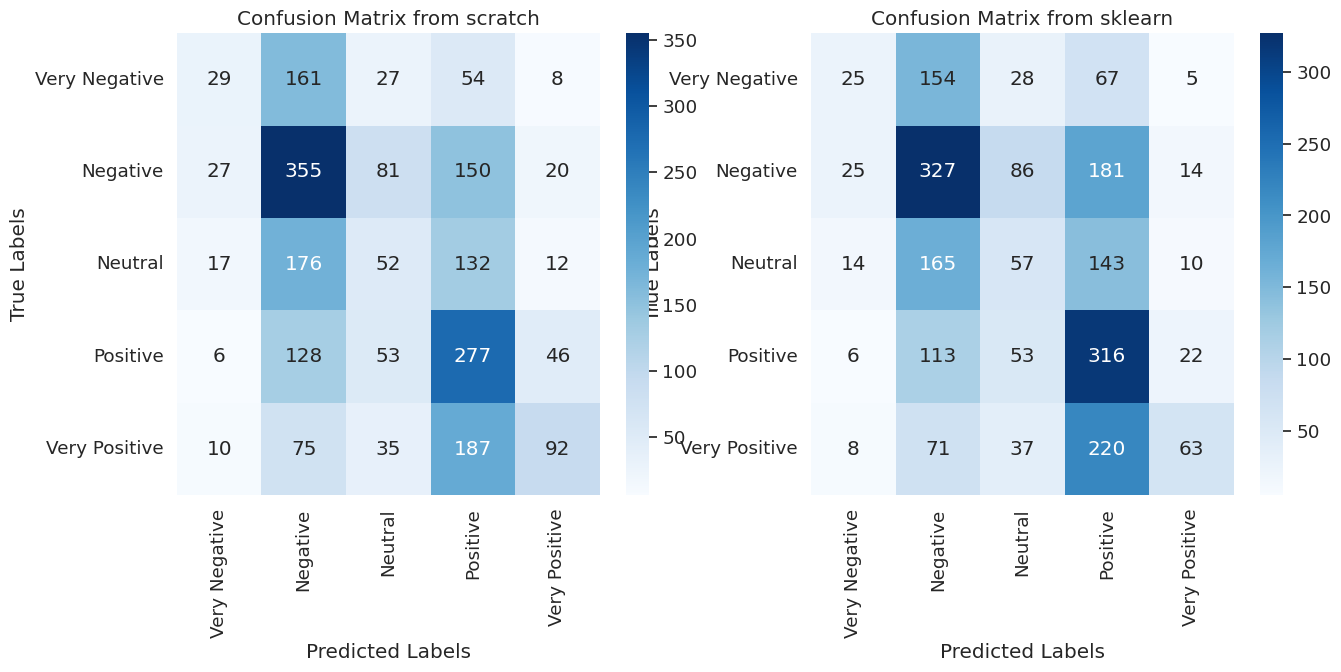

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Create a figure with 1 row and 2 columns

sns.set(font_scale=1.2)

# Plot the first heatmap in the first subplot
sns.heatmap(c, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_title('Confusion Matrix from scratch')

# Plot the second heatmap in the second subplot
sns.heatmap(c2, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')
ax2.set_title('Confusion Matrix from sklearn')

plt.show()


In [ ]:
print(table1)
print(table2)

+---------------+-------------+----------+------------+
| Class         |   Precision |   Recall |   F1-Score |
+===============+=============+==========+============+
| Class 0       |    0.325843 | 0.103943 |   0.157609 |
+---------------+-------------+----------+------------+
| Class 1       |    0.396648 | 0.560821 |   0.46466  |
+---------------+-------------+----------+------------+
| Class 2       |    0.209677 | 0.133676 |   0.163265 |
+---------------+-------------+----------+------------+
| Class 3       |    0.34625  | 0.543137 |   0.422901 |
+---------------+-------------+----------+------------+
| Class 4       |    0.516854 | 0.230576 |   0.318891 |
+---------------+-------------+----------+------------+
| Macro-average |    0.359054 | 0.314431 |   0.305465 |
+---------------+-------------+----------+------------+
+---------------+-------------+-----------+------------+
| Class         |   Precision |    Recall |   F1-Score |
+===============+=============+===========+===